### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [13]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [14]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [15]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

## Change these to select data

In [16]:
table_names = ['civil_liberties', \
               'political_rights', \
               #'freedom_status', \
               #'corruption_perception', \
               'female_legislators', \
               'population_growth', \
               'population_female', \
               #'under_5_mortality', \
               'life_expectancy', \
               #'population_0_14', \
               'population_15_64',  \
               #'population_65_up', \
               #'terror_new', \
               #'peace_new', \
               #'refugees_percapita', \
               'zscores']

In [17]:
x_cols = table_names[:-1]

In [18]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [19]:
full_data = pd.DataFrame()

In [20]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['year', 'countrycode'])
    full_data = pd.concat([full_data, year_data])
    


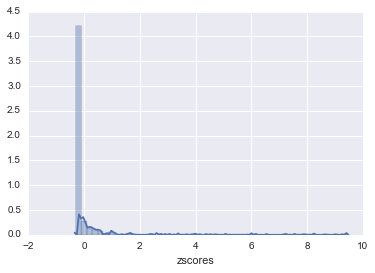

In [21]:
sns.distplot(full_data.dropna()['zscores'].astype(float))

(array([ 989.,   22.,    7.,    7.,    7.,    2.,    3.,    3.,    5.,    4.]),
 array([-0.29313644,  0.67991785,  1.65297214,  2.62602643,  3.59908072,
         4.57213501,  5.5451893 ,  6.51824359,  7.49129788,  8.46435217,
         9.43740646]),
 <a list of 10 Patch objects>)

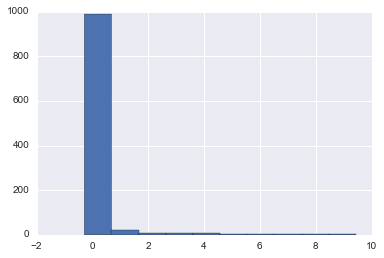

In [22]:
import pylab as pl

pl.hist(sorted(list(full_data.dropna()['zscores'].astype(float))))



In [23]:
full_data.head()

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 AFG                        6                 5                27.7   
     AGO                        5                 6                37.3   
     ALB                        3                 3                 7.1   
     ARE                        5                 6                22.5   
     ARG                        2                 2                40.0   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 AFG                   2.485315          48.512909        58.225024   
     AGO                   3.374180          50.493712        49.847390   
     ALB                  -0.767343          49.610212        76.632317   
     ARE                  13.810060          25.880062        76.307756   
     ARG                   1.025393          51.087196        75.166268   

                  population_15_64       zscores  
year countrycode                                  
2008 AFG                 49.946087   6.546331355  
     AGO                 49.356104   0.281696206  
     ALB                 66.816430   0.055357722  
     ARE                 84.600650  -0.267222176  
     ARG                 63.456290   -0.26793528

In [24]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [25]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

civil_liberties  political_rights  female_legislators  \
year countrycode                                                          
2008 FJI                        4                 6                 NaN   
     GIN                        5                 7                 NaN   
     LUX                        1                 1                23.3   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     TKM                        7                 7                 NaN   
     VUT                        2                 2                 3.8   
2009 FJI                        4                 6                 NaN   
     GIN                        6                 7                 NaN   
     LUX                        1                 1                20.0   
     MDG                        4                 6                 NaN   
     MMR                        7                 7                 NaN   
     SSD                      NaN               NaN                 NaN   
     VUT                        2                 2                 3.8   
     WSM                        2                 2                 8.2   
2010 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     LUX                        1                 1                20.0   
     NER                        4                 5                 NaN   
     SSD                      NaN               NaN                 NaN   
     TZA                        3                 3                 NaN   
2011 FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   
     HRV                        2                 1                23.8   
     LBY                        6                 7                 NaN   
     LUX                        1                 1                25.0   
     ZAR                        6                 6                 NaN   
2012 FJI                        4                 6                 NaN   
     GHA                        2                 1                 NaN   
     GIN                        5                 5                 NaN   
     LKA                        4                 5                 5.8   
     LUX                        1                 1                21.7   
2013 ARG                        2                 2                 NaN   
     CAF                        7                 7                 NaN   
     EGY                        5                 6                 NaN   
     FJI                        4                 6                 NaN   
     GIN                        5                 5                 NaN   

                  population_growth  population_female  life_expectancy  \
year countrycode                                                          
2008 FJI                   1.010417          48.947707        69.022024   
     GIN                   2.671069          49.966108        54.777585   
     LUX                   1.787497          50.493425        80.539024   
     MMR                   0.651129          51.176312        64.367610   
     SSD                   4.362664          50.051550        52.593317   
     TKM                   1.213341          50.724437        64.756073   
     VUT                   2.416066          49.142388        70.254756   
2009 FJI                   1.020386          48.947824        69.202854   
     GIN                   2.728375          49.955495        55.556146   
     LUX                   1.851775          50.416014        80.636585   
     MDG                   2.814994          50.195519        62.918171   
     MMR                   0.663518          51.184720        64.643561   
     SSD                   4.403674       

In [26]:
full_data = full_data.dropna()

In [27]:
#Get Z scores of rows
for col in x_cols:
    full_data[col] = full_data[col].astype(float)
    full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


#### Get the score values WITHOUT cross validating 

In [28]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    roc_auc_value = roc_auc_score(y_test,y_pred)
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: ()'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value, \
                                                                       roc_auc_value))
    else:
        return accuracy_score_value, \
               precision_score_value, \
               recall_score_value, \
               f1_score_value, \
               roc_auc_value, \
               feature_importances

In [29]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [30]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9111111111111111
Precision: 0.6666666666666666
Recall: 0.7555555555555555
f1: 0.7083333333333334
ROC AUC: ()


In [31]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8063492063492064
Precision: 0.3620689655172414
Recall: 0.4666666666666667
f1: 0.4077669902912621
ROC AUC: ()


In [32]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7492063492063492
Precision: 0.3111111111111111
Recall: 0.6222222222222222
f1: 0.4148148148148148
ROC AUC: ()


In [33]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.8698412698412699
Precision: 0.6666666666666666
Recall: 0.17777777777777778
f1: 0.2807017543859649
ROC AUC: ()


In [34]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9079365079365079
Precision: 0.75
Recall: 0.5333333333333333
f1: 0.6233766233766235
ROC AUC: ()


#### Print the ROC curve for a model

In [35]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.964156378600823


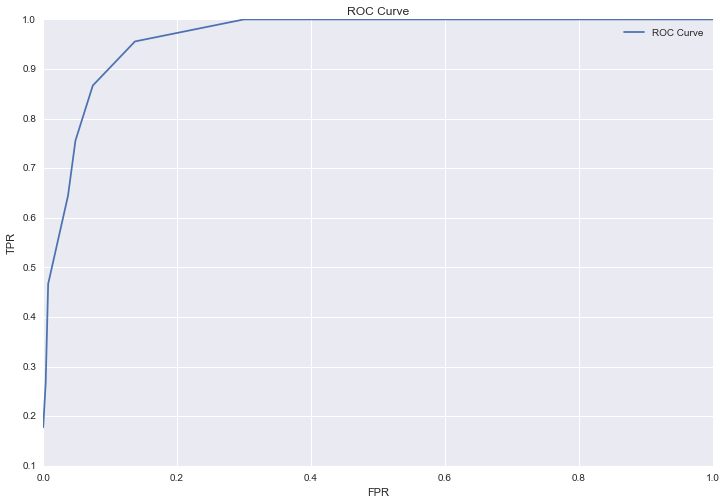

In [36]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

#### Cross Validate and Return Scores 

In [37]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=1)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [38]:
getScoreValuesByCV(X,y)

Accuracy: 0.9589695911471916
Precision: 0.8623891866383524
Recall: 0.8653225806451614
f1: 0.8628064029582057
ROC AUC: 0.92032998657517


In [39]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9465928932628858
Precision: 0.8608405474682013
Recall: 0.7760080645161291
f1: 0.8009936423729528
ROC AUC: 0.9664055397166409


In [40]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7207147554366313
Precision: 0.28659782556715907
Recall: 0.5798387096774194
f1: 0.38337993592387665
ROC AUC: 0.7184708855325689


In [41]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.9351640626771582
Precision: 0.7936117067516661
Recall: 0.7443548387096774
f1: 0.8008318338250081
ROC AUC: 0.8713956520660673


In [42]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8627633279666205
Precision: 0.8333333333333333
Recall: 0.10221774193548387
f1: 0.18001375988992088
ROC AUC: 0.743819996922211


## Modeling with Over Sampling of Training Set

In [43]:
def oversample_data(X_t, y_t, ratio):
    x_columns = X_t.columns
    
    X_t = X_t.reset_index(drop=True).as_matrix()
    y_t = y_t.reset_index(drop=True).as_matrix()

    smote = OverSampler(ratio=ratio, verbose=False)
    smox, smoy = smote.fit_transform(X_t, y_t)
    X_t = pd.DataFrame(smox, columns=x_columns)
    y_t = pd.Series(smoy)
    return X_t, y_t


In [44]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [45]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])

X_train, y_train = oversample_data(X_train, y_train, ratio)

In [46]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.9142857142857143
Precision: 0.6730769230769231
Recall: 0.7777777777777778
f1: 0.7216494845360825
ROC AUC: ()


In [47]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9523809523809523
Precision: 0.8260869565217391
Recall: 0.8444444444444444
f1: 0.8351648351648352
ROC AUC: ()


In [48]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.638095238095238
Precision: 0.2283464566929134
Recall: 0.6444444444444445
f1: 0.33720930232558144
ROC AUC: ()


In [49]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6253968253968254
Precision: 0.21705426356589147
Recall: 0.6222222222222222
f1: 0.32183908045977017
ROC AUC: ()


In [50]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.9111111111111111
Precision: 0.673469387755102
Recall: 0.7333333333333333
f1: 0.702127659574468
ROC AUC: ()


In [51]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.6888888888888889
Precision: 0.2523364485981308
Recall: 0.6
f1: 0.3552631578947368
ROC AUC: ()


## Confusion Matrix

In [52]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with or without oversampling

## getCrossValScoresBySSS

This class is instantiated by doing the following:
    
    yourinstance = getCrossValScoresBySSS(X, y, test_size=0.3, n_iter=30)
    
Where:
* X is a pandas dataframe of the features
* y is a series of the classifiers
* test_size is the test size for the train/test splits
* n_iter is the number of iterations for cross validation

This object has the following methods:

    yourinstance.get_multi_models(oversample=True)
    
    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, get_models_avg=False, get_features=True, get_cm=False, verbose=True)

### get_multi_models

    yourinstance.get_multi_models(oversample=True)

Where:
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
    
This returns a dataframe with the Accuracy, Precision, Recall, F1, and ROC AUC scores for various models.

### get_single_model

    yourinstance.get_single_model(model=KNeighborsClassifier(n_neighbors=2), oversample=True, get_models_avg=False, get_features=True, get_cm=False, verbose=True)
    
Where:
* model is the model to be attempted on the data
* oversample is a boolean that determines if SMOTE should be performed on the training sets for each cross validation
* get_models_avg is a boolean value. If True it will out put an average of the scores results for multiple models. If false it will only model for the model specified
* get_features is a boolean value. If True it will attempt to get the feature importances of the model.
* get_cm is a boolean value. If True it will output a confusion matrix of the model (or the average prediction).
* verbose is a boolean value. If True it will print out the score values for Accuracy, Precision, Recall, F1, and ROC AUC. If False it will just return them.




To do: 

add a method for specifying year

    X.loc[year, :]

return scores for predicting that year with the model.

In [102]:
class getCrossValScoresBySSS(object):
    
    def __init__(self, 
                 local_X, 
                 local_y,
                 test_size=0.3,
                 n_iter=50 
                ):
        self.model_list = [\
                          KNeighborsClassifier(n_neighbors=2), \
                          SVC(), \
                          LogisticRegression(), \
                          BernoulliNB(), \
                          GaussianNB(), \
                          RandomForestClassifier(n_estimators=30), \
                          DecisionTreeClassifier() \
                          ]
        
        self.index_func = [\
                      'KNeighborsClassifier(n_neighbors=2)', \
                      'SVC()', \
                      'LogisticRegression()', \
                      'BernoulliNB()', \
                      'GaussianNB()', \
                      'RandomForestClassifier(n_estimators=30)', \
                      'DecisionTreeClassifier()' \
                      ]
        
        self.initialize_scores()
        self.score_dict = {}

        self.x_cols = list(local_X.columns)
        self.ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
        self.sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    def initialize_scores(self):
        self.acc_array = []
        self.prec_array = []
        self.recall_array = []
        self.f1_array = []
        self.roc_auc_array = []
        self.feature_imp_array = []
        
    def get_multi_models(self, oversample=True, year=None):
        self.score_dict = {}
        models_acc = []
        models_prec = []
        models_rec = []
        models_f1 = []
        models_roc_auc = []
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROCAUC']
        
        for a_model in self.model_list:
            self.initialize_scores()
            
            for train_index, test_index in self.sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]
                
                if oversample:
                    X_train, y_train = oversample_data(X_train, y_train, self.ratio)
                    
                if year != None:
                    X_test, y_test = self.test_conversion_for_year(X_test, y_test, year)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, roc_auc_value, _ = getScoreValues(X_train, 
                                                                       X_test, 
                                                                       y_train, 
                                                                       y_test, 
                                                                       model=a_model, 
                                                                       verbose=False,
                                                                       get_features=False)
                
                self.acc_array.append(accuracy_score_value)
                self.prec_array.append(precision_score_value)
                self.recall_array.append(recall_score_value)
                self.f1_array.append(f1_score_value)
                self.roc_auc_array.append(roc_auc_value)
                
            mean_acc = np.mean(self.acc_array)
            mean_prec = np.mean(self.prec_array)
            mean_recall = np.mean(self.recall_array)
            mean_f1 = np.mean(self.f1_array)
            mean_roc_auc = np.mean(self.roc_auc_array)
            
            models_acc.append(mean_acc)
            models_prec.append(mean_prec)
            models_rec.append(mean_recall)
            models_f1.append(mean_f1)
            models_roc_auc.append(mean_roc_auc)
            
        self.score_dict['Accuracy'] = models_acc
        self.score_dict['Precision'] = models_prec
        self.score_dict['Recall'] = models_rec
        self.score_dict['F1'] = models_f1
        self.score_dict['ROCAUC'] = models_roc_auc
        
        df = pd.DataFrame(self.score_dict, columns=col_names, index=self.index_func)
        return df
    
    def get_single_model(self,
                         model=KNeighborsClassifier(n_neighbors=2),
                         oversample=True,
                         year=None,
                         get_models_avg=False,
                         get_features=True,
                         get_cm=False,
                         verbose=True
                        ):
        
        self.initialize_scores()
        
        for train_index, test_index in self.sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            if oversample:
                X_train, y_train = oversample_data(X_train, y_train, self.ratio)
                
            if year != None:
                X_test, y_test = self.test_conversion_for_year(X_test, y_test, year)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in self.model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)
                roc_auc_value = roc_auc_array(y_test, y_pred)

                self.acc_array.append(accuracy_score_value)
                self.prec_array.append(precision_score_value)
                self.recall_array.append(recall_score_value)
                self.f1_array.append(f1_score_value)
                self.roc_auc_array.append(roc_auc_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, roc_auc_value, \
                feature_importances = getScoreValues(X_train, 
                                                     X_test, 
                                                     y_train,
                                                     y_test, 
                                                     model=model, 
                                                     verbose=False,
                                                     get_features=get_features)


                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    y_pred = self.get_cm_pred(model, X_train, y_train, X_test)

                self.acc_array.append(accuracy_score_value)
                self.prec_array.append(precision_score_value)
                self.recall_array.append(recall_score_value)
                self.f1_array.append(f1_score_value)
                self.roc_auc_array.append(roc_auc_value)
                self.feature_imp_array.append(feature_importances)

        if get_cm:
            try:
                cm = confusion_matrix(y_test, average_prediction)
            except:
                cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(self.acc_array)
        mean_prec = np.mean(self.prec_array)
        mean_recall = np.mean(self.recall_array)
        mean_f1 = np.mean(self.f1_array)
        mean_roc_auc = np.mean(self.roc_auc_array)
        try:
            mean_feature_imp = np.mean(self.feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
            
            
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(mean_acc, \
                                                                                        mean_prec, \
                                                                                        mean_recall,\
                                                                                        mean_f1, \
                                                                                        mean_roc_auc))

        else:
            return mean_acc, mean_prec, mean_recall, mean_f1, mean_roc_auc
    
    def get_cm_pred(self, model, X_t, y_t, X_ts):
        temp_model = model
        temp_model.fit(X_t, y_t)
        y_pd = temp_model.predict(X_ts)
        return y_pd
    
    def test_conversion_for_year(self, X_te, y_te, year):
        try:
            X_te = X_te.loc[year, :]
            y_te = y_te.loc[year, :]
            return X_te, y_te

        except:
            print('Bad Year')
    

In [103]:
X = full_data[x_cols]
y = full_data['zscores']

## Scores for various models

#### With oversampling

In [104]:
pol_modeling = getCrossValScoresBySSS(X,y)

In [105]:
pol_modeling.get_multi_models()

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.954921,0.844254,0.860851,0.850883,0.916134
SVC(),0.818730,0.446162,0.848085,0.583400,0.830834
LogisticRegression(),0.667873,0.262034,0.671489,0.376481,0.669364
BernoulliNB(),0.609841,0.223557,0.653191,0.332725,0.627715
GaussianNB(),0.581016,0.209357,0.654043,0.316781,0.611126
RandomForestClassifier(n_estimators=30),0.952317,0.851153,0.826809,0.837984,0.900568
DecisionTreeClassifier(),0.931111,0.780771,0.756596,0.765681,0.859156


#### Without oversampling

In [74]:
pol_modeling.get_multi_models(oversample=False)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.942857,0.874896,0.721277,0.789956,0.851497
SVC(),0.883492,0.791356,0.304965,0.435236,0.644957
LogisticRegression(),0.863704,0.865873,0.104255,0.184202,0.550573
BernoulliNB(),0.812381,0.401687,0.516312,0.451008,0.690308
GaussianNB(),0.731534,0.298795,0.589362,0.395813,0.672915
RandomForestClassifier(n_estimators=30),0.945608,0.885466,0.730496,0.799232,0.856915
DecisionTreeClassifier(),0.924233,0.742884,0.763121,0.749941,0.857804


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.9521693121693121
Precision: 0.8330129607067633
Recall: 0.8574468085106383
f1: 0.8427709840009914
ROC AUC: 0.9131139515190008


n =  2
Avg Feature Importance: None
Accuracy: 0.9554497354497354
Precision: 0.8428081131107646
Recall: 0.8680851063829785
f1: 0.8530733759957454
ROC AUC: 0.9194281253307929


n =  3
Avg Feature Importance: None
Accuracy: 0.9297354497354497
Precision: 0.7054299780719064
Recall: 0.9141843971631206
f1: 0.7954721210247183
ROC AUC: 0.9233235418651424




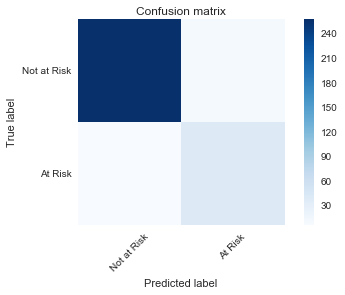

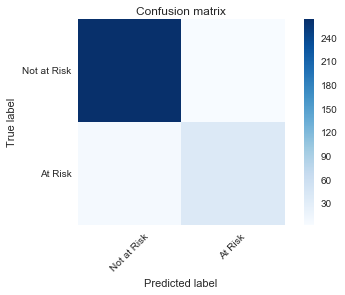

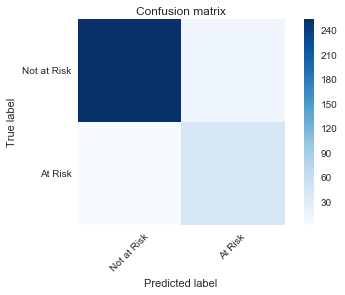

In [73]:
for n in range(1,4):
    print('n = ', n)
    pol_modeling.get_single_model(model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.12028238  0.10542663  0.11778884  0.16648999  0.13180228  0.14906754
  0.20914234]
Accuracy: 0.9574603174603175
Precision: 0.8601714030420554
Recall: 0.8560283687943263
f1: 0.8569120826119387
ROC AUC: 0.9156385625066157


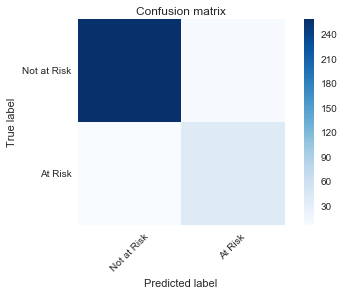

In [61]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.12138225  0.10270884  0.11815154  0.17045065  0.12669724  0.15441116
  0.20619831]
Accuracy: 0.9535449735449735
Precision: 0.854454370351919
Recall: 0.8319148936170213
f1: 0.841690903242238
ROC AUC: 0.9033952577537843


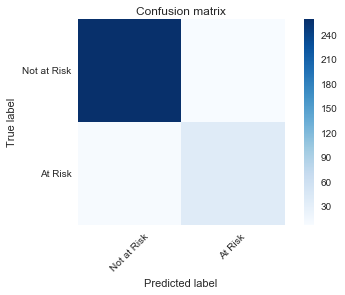

In [62]:
pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.11825411  0.09157728  0.10509774  0.1988876   0.14473493  0.12022577
  0.22122257]
Accuracy: 0.9288888888888889
Precision: 0.7777487590607061
Recall: 0.7368794326241136
f1: 0.7546329152166141
ROC AUC: 0.8497208108394199


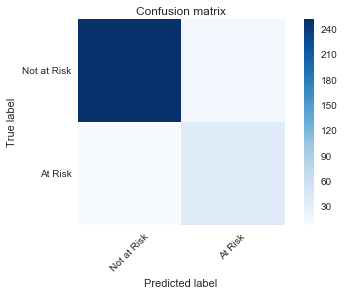

In [63]:
pol_modeling.get_single_model(model=DecisionTreeClassifier(), get_cm = True)

### Random forest, different number of trees

In [ ]:
forest_acc = []
forest_prec = []
forest_rec = []
forest_f1 = []
forest_range = list(range(1,30))
for trees in forest_range:
    acc, prec, rec, f1 = pol_modeling.get_single_model(model=RandomForestClassifier(n_estimators=trees), verbose=False)
    forest_acc.append(acc)
    forest_prec.append(prec)
    forest_rec.append(rec)
    forest_f1.append(f1)

plt.figure(figsize=(11,7))
plt.plot(forest_range, forest_acc, label='Accuracy')
plt.plot(forest_range, forest_prec,label='Precision')
plt.plot(forest_range, forest_rec,label='Recall')
plt.plot(forest_range, forest_f1,label='F1')

plt.legend(loc='best')
plt.xlabel('Num Trees')
plt.ylabel('Score')
plt.title('Scores at various tree sizes')
plt.show()

    

### Model averages:

In [ ]:
pol_modeling.get_single_model(get_models_avg=True)

## Testing for a single year

### With Oversampling

In [106]:
pol_modeling.get_multi_models(year=2013)

,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.931950,0.768675,0.807890,0.776435,0.880752
SVC(),0.799812,0.413214,0.742854,0.521418,0.776341
LogisticRegression(),0.701190,0.288904,0.646126,0.395127,0.677208
BernoulliNB(),0.650610,0.249343,0.675091,0.359725,0.660519
GaussianNB(),0.594769,0.219105,0.634513,0.322659,0.610860
RandomForestClassifier(n_estimators=30),0.912458,0.718955,0.692943,0.693923,0.821511
DecisionTreeClassifier(),0.887213,0.618870,0.610110,0.602734,0.772513


In [87]:
pol_modeling.get_multi_models(year=2013, oversample=False)

/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kenn/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,F1,ROCAUC
KNeighborsClassifier(n_neighbors=2),0.909658,0.743849,0.543431,0.617631,0.756679
SVC(),0.871530,0.634881,0.371325,0.452748,0.665376
LogisticRegression(),0.870336,0.566667,0.110266,0.177756,0.554384
BernoulliNB(),0.821865,0.429182,0.533783,0.464914,0.704450
GaussianNB(),0.765364,0.321623,0.636647,0.421407,0.710967
RandomForestClassifier(n_estimators=30),0.912502,0.758704,0.582275,0.641033,0.774419
DecisionTreeClassifier(),0.886652,0.613192,0.655891,0.616611,0.791068
